# Electrode State of Health

This notebook demonstrates some utilities to work with electrode State of Health (also sometimes called electrode stoichiometry), using the algorithm from Mohtat et al [1]

[1] Mohtat, P., Lee, S., Siegel, J. B., & Stefanopoulou, A. G. (2019). Towards better estimability of electrode-specific state of health: Decoding the cell expansion. Journal of Power Sources, 427, 101-111.

In [1]:
%pip install pybamm -q
import pybamm
import matplotlib.pyplot as plt
import numpy as np

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Create and solve model

In [3]:
spm = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 3V",
    "Hold at 3V until C/50",
])
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()
spm_sol.plot([
    "Terminal voltage [V]", 
    "Current [A]", 
    "Negative electrode SOC",
    "Positive electrode SOC",
])

SolverError: Could not determine which event was triggered (possibly due to NaNs)

## Solve for electrode SOH variables

Given a total amount of lithium, $n_{Li}$, electrode capacities, $C_n$ and $C_p$, and voltage limits, $V_{min}$ and $V_{max}$, we can solve for the min and max electrode SOCs, $x_0$, $x_{100}$, $y_0$, and $y_{100}$,  and the cell capacity, $C$, using the algorithm from Mohtat et al [1].
First, we find $x_{100}$ and $y_{100}$ using
$$
\begin{align}
n_{Li} &= \frac{3600}{F}(y_{100}C_p + x_{100}C_n),
\\
V_{max} &= U_p(y_{100}) - U_n(x_{100}).
\end{align}
$$
Then, we find $C$ using
$$
\begin{align}
V_{min} &= U_p(y_{0}) - U_n(x_{0})
\\
&= U_p\left(y_{100} + \frac{C}{C_p}\right) - U_n\left(x_{100} - \frac{C}{C_n}\right)
\end{align}
$$
Finally, $x_0$ and $y_0$ are simply defined as
$$
\begin{align}
x_0 &= x_{100} - \frac{C}{C_n},
\\
y_0 &= y_{100} + \frac{C}{C_p}.
\end{align}
$$
We implement this in pybamm as an algebraic model.

In [3]:
param = pybamm.LithiumIonParameters()

Vmin = 3
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

Un = param.U_n_dimensional
Up = param.U_p_dimensional
T_ref = param.T_ref

In [13]:
model = pybamm.BaseModel()
x100 = pybamm.Variable("x100")
C = pybamm.Variable("C")

y100 = (n_Li * param.F / 3600 - x100 * Cn) / Cp
x0 = x100 - C/Cn
y0 = y100 + C/Cp

model.algebraic = {
    x100: Up(y100, T_ref) - Un(x100, T_ref) - Vmax,
    C: Up(y0, T_ref) - Un(x0, T_ref) - Vmin,
}
model.initial_conditions = {
    x100: 1,
    C: Cp,
}
model.variables = {
    "x_100": x100,
    "y_100": y100,
    "C": C,
    "x_0": x0,
    "y_0": y0,
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])
for var in ["x_100", "y_100", "C", "x_0", "y_0"]:
    print(var, ":", sol[var].data[0])

x_100 : 0.8333952418070643
y_100 : 0.03352393941868425
C : 4.976233834657047
x_0 : 0.0003105051235081646
y_0 : 0.8921330277182218


This model is implemented in PyBaMM as the `ElectrodeSOH` model

In [19]:
model = pybamm.lithium_ion.ElectrodeSOH()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
esoh_sol = sim.solve(
    [0],
    inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
)
for var in ["x_100", "y_100", "C", "x_0", "y_0"]:
    print(var, ":", esoh_sol[var].data[0])

x_100 : 0.8333952418070643
y_100 : 0.03352393941868425
C : 4.976233834657047
x_0 : 0.0003105051235081646
y_0 : 0.8921330277182218


## Check against simulations

Plotting the SPM simulations against the eSOH calculations validates the min/max stoichiometry calculations

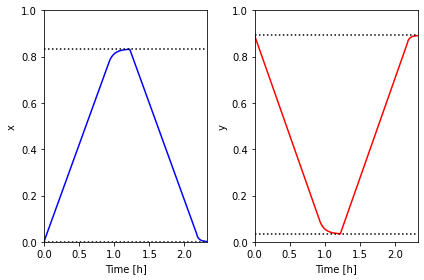

In [36]:
t = spm_sol["Time [h]"].data
x_spm = spm_sol["Negative electrode SOC"].data
y_spm = spm_sol["Positive electrode SOC"].data

x_0 = esoh_sol["x_0"].data * np.ones_like(t)
y_0 = esoh_sol["y_0"].data * np.ones_like(t)
x_100 = esoh_sol["x_100"].data * np.ones_like(t)
y_100 = esoh_sol["y_100"].data * np.ones_like(t)

fig, axes = plt.subplots(1,2)

axes[0].plot(t, x_spm, "b")
axes[0].plot(t, x_0, "k:")
axes[0].plot(t, x_100, "k:")
axes[0].set_ylabel("x")
    
axes[1].plot(t, y_spm, "r")
axes[1].plot(t, y_0, "k:")
axes[1].plot(t, y_100, "k:")
axes[1].set_ylabel("y")
    
for k in range(2):
    axes[k].set_xlim([t[0],t[-1]])
    axes[k].set_ylim([0,1])    
    axes[k].set_xlabel("Time [h]")
    
fig.tight_layout()
